# Importing Libraries

In [6]:
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Download MNIST Handwritten Digits Dataset

In [7]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Define Activation Functions

In [8]:
def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def softmax(x, derivative=False):
    if derivative:
        return x * (1 - x)
    return np.exp(x) / np.sum(np.exp(x))

# Define the Model Class

In [9]:
class Model:
    
    def __init__(self):
        self.layers = []

    def add_layer(self, activation, output_dim: int, input_dim: int = None):
        if input_dim is None and len(self.layers) == 0:
            raise ValueError("Input dimension must be specified for the first layer")
        input_dim = self.layers[-1]["weights"].shape[0] if input_dim is None else input_dim
        weight_matrix = np.random.randn(output_dim, input_dim+1)
        layer = {}
        layer["weights"] = weight_matrix
        layer["activation"] = activation
        self.layers.append(layer)

    def summary(self):
        no_params = 0
        for i, layer in enumerate(self.layers):
            params = layer["weights"].shape
            curr_params = params[0] * params[1]
            no_params += curr_params
            print(f"Layer {i}: ", end=" ")
            print(f"Params: {params} = {curr_params}", end=" ")
            print(f" Activation: {layer['activation'].__name__}")
        print("-"*60)
        print("Total Trainable Params:", no_params)

    def forward_step(self, layer_no, input):
        if input.ndim == 1:
            input = np.append(input, 1)
        else:
            input = np.vstack([input, np.ones(input.shape[1])])
        output = self.layers[layer_no]["weights"] @ input
        return output

    def get_prev_delta(self, layer_no, layer_output, next_delta):
        W = self.layers[layer_no+1]["weights"].T
        activation = self.layers[layer_no]["activation"]
        output_part = activation(layer_output, derivative=True)
        output_part = np.append(output_part, 0)
        result = np.multiply(W @ next_delta, output_part)
        return result[:-1]
        
    def train_step(self, x, y, learning_rate, total):
        L = len(self.layers)
        outputs = []
        next_input = x
        for i in range(len(self.layers)):
            output = self.forward_step(i, next_input)
            outputs.append(output)
            next_input = self.layers[i]["activation"](output)
        y_hat = next_input
        deltas = [None]*L
        
        # Calculate deltas
        deltas[L-1] = (y_hat - y) * self.layers[L-1]["activation"](y_hat, derivative=True)
        for i in range(L-2, -1, -1):
            deltas[i] = self.get_prev_delta(i, outputs[i], deltas[i+1])
        
        # Update weights
        for i in range(L):
            delta_val = deltas[i]
            prev_output = x if i == 0 else outputs[i-1]
            delta_val = np.reshape(delta_val, (-1, 1))
            prev_output = np.append(prev_output, 1)
            prev_output = np.reshape(prev_output, (1, -1))
            self.layers[i]["weights"] -= learning_rate * (delta_val @ prev_output) / total

    def dimention_check(self, X, y: None):
        # X: Checks
        if len(X.shape) != 2:
            raise ValueError("Input shape must be (N, D), N: smaples")
        if X.shape[1] != self.layers[0]["weights"].shape[1] - 1:
            req_dim = self.layers[0]["weights"].shape[1] - 1
            got_dim = X.shape[0]
            raise ValueError(
                f"Input shape {got_dim} does not match input dimension {req_dim}")
        if y is not None:
            # Y: Checks
            if len(y.shape) != 2:
                raise ValueError("Input shape must be (N, D), N: smaples")
            if y.shape[1] != self.layers[-1]["weights"].shape[0]:
                req_dim = self.layers[-1]["weights"].shape[0]
                got_dim = y.shape[0]
                raise ValueError(
                    f"Output shape {got_dim} does not match output dimension {req_dim}")
            if y.shape[0] != X.shape[0]:
                raise ValueError("Number of samples in X and y do not match")

    def predict(self, X):
        self.dimention_check(X, None)
        next_input = X.T
        for i in range(len(self.layers)):
            output = self.forward_step(i, next_input)
            next_input = np.array(
                [self.layers[i]["activation"](col) for col in output.T]).T
        return next_input

    def cost(self, X, y):
        all_y_hat = self.predict(X)
        all_y_hat = all_y_hat.T
        return np.mean(np.sum((y - all_y_hat)**2, axis=1))

    def train(self, X, y, learning_rate, epochs):
        self.dimention_check(X, y)
        initial_cost = self.cost(X, y)
        costs = [initial_cost]
        print(f"Initial Cost: {initial_cost}")
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            for i in tqdm(range(X.shape[0])):
                self.train_step(X[i], y[i], learning_rate, X.shape[0])
            costs += [self.cost(X, y)]
            print(f"Cost: {costs[-1]}")
        return costs

# Train the Model

In [10]:
model = Model()
model.add_layer(sigmoid, 16, 784)
model.add_layer(sigmoid, 16)
model.add_layer(softmax, 10)
model.summary()

costs = model.train(train_images, train_labels, learning_rate=700, epochs=10)

Layer 0:  Params: (16, 785) = 12560  Activation: sigmoid
Layer 1:  Params: (16, 17) = 272  Activation: sigmoid
Layer 2:  Params: (10, 17) = 170  Activation: softmax
------------------------------------------------------------
Total Trainable Params: 13002


Initial Cost: 1.0879082855010151
Epoch 1/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.46985710412740456
Epoch 2/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.41570668547967216
Epoch 3/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.4060192306856192
Epoch 4/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.380264357280763
Epoch 5/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.38111775810336357
Epoch 6/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.32840122605928884
Epoch 7/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.3084222786095018
Epoch 8/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.3006555860329664
Epoch 9/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.3000528366737029
Epoch 10/10


  0%|          | 0/60000 [00:00<?, ?it/s]

Cost: 0.2750974214133223


# Plot the training Cost

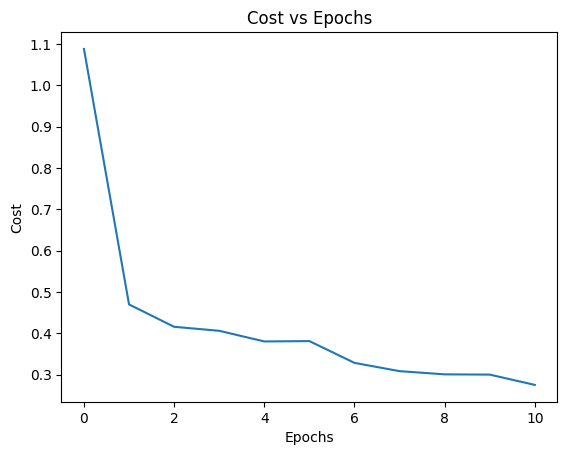

In [11]:
plt.plot(costs)
plt.title("Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# Predeict for Test Data

In [13]:
y_pred = model.predict(test_images).T
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

accuracy = np.mean(y_pred == y_true)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 81.94%
